# Import libraries

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import loadtxt
import warnings
import sklearn
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import datetime
from sklearn.metrics import accuracy_score

# 머신러닝 모델 저장
import pickle
import joblib
# from sklearn.externals import joblib

import sqlalchemy
from sqlalchemy import (create_engine, MetaData, Table, Column, Integer, String, DateTime)

from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm import Session

from datetime import datetime

warnings.filterwarnings('ignore')

In [ ]:
sns.set(font="Malgun Gothic",
        rc={"axes.unicode_minus":False},
        style="whitegrid")
# 폰트가 선명하게 보이기 위해
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# Load Data

In [ ]:
file_path = '/content/drive/MyDrive/motion_dataset/'
train_path = file_path + 'train_dataset/'
test_path = file_path + 'test_dataset/'

In [ ]:
# accx-> type(accx) : numpy.ndarray
accx = np.loadtxt(train_path+'acc_X.txt')
accy = np.loadtxt(train_path+'acc_Y.txt')
accz = np.loadtxt(train_path+'acc_Z.txt')
gyrox = np.loadtxt(train_path+'gyro_X.txt')
gyroy = np.loadtxt(train_path+'gyro_Y.txt')
gyroz = np.loadtxt(train_path+'gyro_Z.txt')
answers = np.loadtxt(train_path+'Answer.txt')

In [ ]:
my_data_names= ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz']

In [ ]:
my_data = [accx, accy, accz, gyrox, gyroy, gyroz]

In [ ]:
# 하나의 배열로 합치고 (n,6) 모양으로 정리하기 = dataset
my_data=map(np.ravel, my_data)
print(f"the original my_data didnt change. the shape of accx : {accx.shape}")
dataset = np.column_stack(my_data)
print(dataset)
print(dataset.shape)

the original my_data didnt change. the shape of accx : (18516, 200)
[[  2.35       -11.24999     -0.05999     -1.0490036   -3.8429918
    2.6371534 ]
 [  2.56       -11.60999     -0.10999     -0.88602215  -3.1503205
    2.2663705 ]
 [  2.64       -11.71999     -0.11999     -0.9634384   -2.865103
    2.2134016 ]
 ...
 [ 11.22         3.03        -3.53999      1.3834947   -2.3394878
    0.29022044]
 [ 11.65         3.13        -3.90999      1.1308734   -2.1683574
    0.35948756]
 [ 12.04         3.18        -4.23999      0.8375068   -1.9279597
    0.35948756]]
(3703200, 6)


In [ ]:
dataset = dataset.reshape((18516,200,6))
print(dataset.shape)

(18516, 200, 6)


In [ ]:
answers.shape

(18516,)

# Explanatory Data Analysis

In [ ]:
# 그래프 기본 스타일 설정
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams['font.size']= 10
plt.rcParams['lines.linewidth']= 1

## Acc and gyro plots of walking data <br> 걷기 데이터의 가속도, 각속도 그래프 확인

In [ ]:
# walking data 불러오기
standing1 = pd.read_csv(test_path+"hansung_standing_1.txt", delimiter="\t", header=None)
standing1 = standing1.iloc[:,-6:] # 대부분 accx ~ gyroy 까지 여섯개 columns가 있지만, 가끔 첫째 열이 '날짜시간'인 파일들도 있어서(파일마다 대중 없음), 일괄적으로 이렇게 처리해주기.
standing1.columns = [0,1,2,3,4,5] 
print(standing1.shape)
print(standing1)
type(standing1)

(30000, 6)
            0       1       2       3       4       5
0      4.8730 -8.4934  2.6793  0.1760  0.0962  0.1304
1      4.5941 -8.6627  2.9382  0.1073  0.4034  0.1061
2      4.3775 -9.0512  3.0279  0.1760  0.0234  0.1668
3      4.3476 -9.0014  2.8984 -0.0908 -0.0008  0.1587
4      4.3376 -8.9915  2.8984 -0.0989 -0.0089  0.1668
...       ...     ...     ...     ...     ...     ...
29995  2.8685 -9.6364  1.3695  0.0224 -0.0130  0.0051
29996  2.8685 -9.6463  1.3695  0.0143  0.0113  0.0051
29997  2.8685 -9.6463  1.3695  0.0224  0.0113  0.0051
29998  2.8586 -9.6463  1.3695  0.0265  0.0153  0.0051
29999  2.8586 -9.6463  1.3695  0.0224  0.0153  0.0091

[30000 rows x 6 columns]


pandas.core.frame.DataFrame

In [ ]:
def makemotionplot(motion_dataframe):
  # 변수 지정하기
  x = np.linspace(0, 4000, 4000)
  y0 = motion_dataframe.loc[:3999, 0]
  y1 = motion_dataframe.loc[:3999, 1]
  y2 = motion_dataframe.loc[:3999, 2] 

  # 그래프 기본 스타일 설정
  plt.style.use('default')
  plt.rcParams['figure.figsize'] = (10,4)
  plt.rcParams['font.size']= 10
  plt.rcParams['lines.linewidth']= 1

  # 그래프 그리기
  fig, ax = plt.subplots()
  ax.plot(x, y0, '-', label = 'acc x')
  ax.plot(x, y1, '-', label = 'acc y')
  ax.plot(x, y2, '-', label = 'acc z')

  temp = ""
  if motion_dataframe == standing1:
    temp = "standing1"

  # 그래프 꾸미기
  plt.title('Acceleration during' + temp )
  plt.xlabel('time(ms)')
  plt.ylabel('acceleration')

  ax.patch.set_facecolor('whitesmoke')
  ax.legend(loc='upper right', frameon = False, fontsize = 10,
            facecolor='w')
  ax.grid(axis='y')
  # ax.spines['left'].set_position('center')        # 왼쪽 축을 가운데 위치로 이동
  ax.spines['right'].set_visible(False)          # 오른쪽 축을 보이지 않도록
  ax.spines['top'].set_visible(False)            # 위 축을 보이지 않도록
  ax.spines['bottom'].set_position(('data', 0))   # 아래 축을 데이터 0의 위치로 이동
  ax.tick_params('both', length=0)

ValueError: ignored

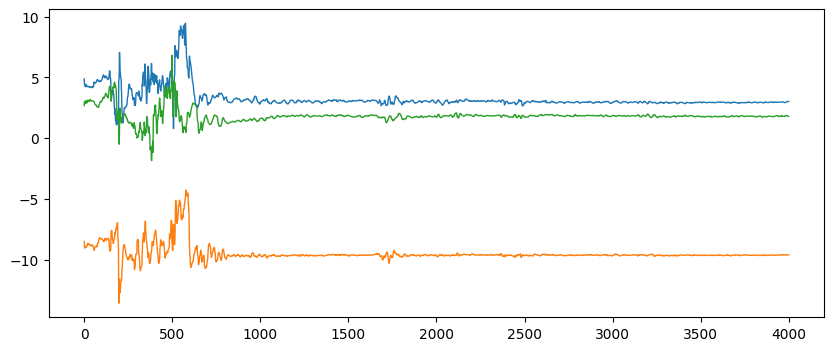

In [ ]:
makemotionplot(standing1)

In [ ]:
def makeplots(behavior_dataframe):
  x = np.linspace(0, 4000, 4000)
  y0 = list(behavior_dataframe[0])[:4000]
  y1 = list(behavior_dataframe[1])[:4000]
  y2 = list(behavior_dataframe[2])[:4000] 
  
  fig, ax = plt.subplots()
  ax.plot(x, y0)
  ax.plot(x, y1)
  ax.plot(x, y2)

  #ax.spines['left'].set_position('center')        # 왼쪽 축을 가운데 위치로 이동
  ax.spines['right'].set_visible(False)          # 오른쪽 축을 보이지 않도록
  ax.spines['top'].set_visible(False)            # 위 축을 보이지 않도록
  ax.spines['bottom'].set_position(('data', 0))   # 아래 축을 데이터 0의 위치로 이동
  ax.tick_params('both', length=0)

# Divide dataset into train set and test set

In [ ]:
# using sklearn.model_selection
trainx, testx, trainy, testy = train_test_split(dataset,
                                                answers,
                                                test_size=0.3,
                                                shuffle = True,
                                                random_state = 1004)

print('X_train shape:', trainx.shape)
print('X_test shape:', testx.shape)
print('y_train shape:', trainy.shape)
print('y_test shape:', testy.shape)

X_train shape: (12961, 200, 6)
X_test shape: (5555, 200, 6)
y_train shape: (12961,)
y_test shape: (5555,)


# Model

## 최종 선정 모델을 위한 하이퍼 파라메터 튜닝
###  **LGBM 주요 하이퍼 파라메터 튜닝**

* random_state: random seed 고정 값

* n_jobs: CPU 사용 갯수

* learning_rate: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1

* n_estimators: 부스팅 스테이지 수. (랜덤포레스트 트리의 갯수 설정과 비슷한 개념). default=100

* max_depth: 트리의 깊이. 과대적합 방지용. 과적합시 max_depth 줄이기. default=3.

* colsample_bytree: 샘플 사용 비율 (max_features와 비슷한 개념). 과대적합 방지용. default=1.0

* application : 모델의 어플리케이션을 정함. 이것이 regression 회귀분석 문제인지, classification 분류 문제인지 정함. default = regression
  * regression 회귀분석
  * binary 이진분류
  * multiclass 다중분류

* boosting: 실행하고자하는 알고리즘 타입 정의. default = gdbt
  *  gdbt:Traditional Gradient Boosting Decision Tree
  * rf : Random Forest
  * dart : Dropouts meet Multiple Additive Regression Trees
  * goss : Gradient-based One-Side Sampling 

* num_leaves : 전체 Tree의 leave 수.  default = 31

* device : 디폴트 값은 cpu 인데 gpu로 변경 가능

* metric : 모델을 구현할 때 손실을 정하기 때문에 중요한 변수 중에 하나입니다. regression과 classification 을 위한 일반적인 손실 값이 아래에 나와있습니다.

  * mae : mean absolute error
  * mse : mean squared error
  * binary_logloss : loss for binary classification
  * multi_logloss : loss for multi classification


참고: https://nicola-ml.tistory.com/51

> 하이퍼 파라미터 튜닝 방안
num_levels의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안입니다.

 

> num_levels는 개별 트리가 가질 수 있는 최대 리프의 개수이고 LightGBM 모델의 복잡도를 제어하는 주요 파라미터입니다. 일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도가 커집니다.
min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_child_samples로 이름이 바뀝니다. 과적합을 개선하기 위한 중요한 파라미터입니다. num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지합니다.
max_depth는 명시적으로 깊이의 크기를 제한합니다. num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는 데 사용합니다.
 

> learning_rate를 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋습니다. 물론 n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있습니다.

 

> 이밖에 과적합을 제어하기 위해서 reg_lambda, reg_alpha와 같은 regularization을 적용하거나 학습 데이터에 사용할 피처의 개수나 데이터 샘플링 레코드 개수를 줄이기 위해 colsample_bytree, subsample파라미터를 적용할 수 있습니다.

In [ ]:
params_lgbm = {
    'learning_rate': [0.005, 0.01, 0.03, 0.05], #0.1, 0.001, 0.003
    'n_estimators': [500, 1000, 2000, 3000], #너무 크게하면 과적합으로 성능 저하 가능
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8, 0.9, 1.0],
}

### **XGB 주요 하이퍼 파라메터 튜닝**
* random_state: random seed 고정 값

* n_jobs: CPU 사용 갯수

* learning_rate: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1

* n_estimators: 부스팅 스테이지 수. (랜덤포레스트 트리의 갯수 설정과 비슷한 개념). default=100

* max_depth: 트리의 깊이. 과대적합 방지용. default=3.

* subsample: 샘플 사용 비율. 과대적합 방지용. default=1.0

* max_features: 최대로 사용할 feature의 비율. 과대적합 방지용. default=1.0

In [ ]:
params_xgb = {
    'learning_rate': [0.005, 0.01, 0.03, 0.05],
    'n_estimators': [500, 1000, 2000, 3000],
    'max_depth': [3, 5, 7],
    'max_features': [0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8, 0.9, 1.0],
}

### **RF 주요 하이퍼 파라메터 튜닝**
* random_state: random seed 고정 값

* n_jobs: CPU 사용 갯수

* max_depth: 깊어질 수 있는 최대 깊이. 과대적합 방지용

* n_estimators: 암상블하는 트리의 갯수

* max_features: best split을 판단할 때 최대로 사용할 feature의 갯수 {‘auto’, ‘sqrt’, ‘log2’}. 과대적합 방지용

* min_samples_split: 트리가 분할할 때 최소 샘플의 갯수. default=2. 과대적합 방지용

In [ ]:
params_rf = {
    'n_estimators': [500, 1000, 2000, 3000],
    'max_depth': [3, 5, 7],
    'max_features': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 4, 6, 8],
}

# 모델 성능 비교 함수 설정


In [ ]:
my_predictions = {}

# prediction plot
def plot_predictions(name_, actual, pred):
    df = pd.DataFrame({'actual': y_test, 'prediction': pred})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()


# evaluation plot
def mse_eval(name_, actual, pred):
    global predictions
    global colors

    plot_predictions(name_, actual, pred)

    mse = mean_squared_error(actual, pred)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)

    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10

    length = len(df)

    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])

    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')

    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)

    plt.show()



# 파이프라인 형태

In [ ]:
def final_model_selection(x_train, y_train, x_test, y_test):
        # lgbm에 들어가기 위해 컬럼명 변환

        # lgbm
        lgbm = LGBMRegressor(random_state=1)
        lgbm.fit(x_train, y_train)
        lgbm_pred = lgbm.predict(x_test)
        mse_lgbm = mean_squared_error(y_test, lgbm_pred)
        # xgb
        xgb = XGBRegressor(random_state=1)
        xgb.fit(x_train, y_train)
        xgb_pred = xgb.predict(x_test)
        mse_xgb = mean_squared_error(y_test, xgb_pred)
        # RF
        rfr = RandomForestRegressor(random_state=1)
        rfr.fit(x_train, y_train)
        rfr_pred = rfr.predict(x_test)
        mse_rf = mean_squared_error(y_test, rfr_pred)

        # mse 기준으로 모델간 비교하여 best 모델선정
        if min(mse_lgbm, mse_xgb , mse_rf) == mse_lgbm:
                params= params_lgbm
                model= LGBMRegressor()
        elif min(mse_lgbm, mse_xgb , mse_rf) == mse_xgb:
                params= params_xgb
                model= XGBRegressor()
        elif min(mse_lgbm, mse_xgb , mse_rf) == mse_rf:
                params= params_rf
                model= RandomForestRegressor()

        # best 모델에서 random search 로 하이퍼 파리미터 최적화
        best_model= RandomizedSearchCV(model, params, random_state=1, cv=5, n_iter=100, scoring='neg_mean_squared_error')
        best_model.fit(x_train, y_train)
        return best_model

In [ ]:
def one_hot_encoding(data):
    if data=="Y":
        return 1
    else:
        return 0